## Installation

!pip install gensim
!pip install wordcloud

## Initialization

In [1]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import keras

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from sklearn import random_projection
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

from keras.layers import Input ,Dense, Dropout, Activation, LSTM
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Reshape
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed
from keras.layers.pooling import GlobalAveragePooling1D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.models import Model
from keras import metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.regularizers import l1

stop_words = set(stopwords.words('english') + list(string.punctuation))

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## Helper Functions

In [3]:
def tokenize(text):
    '''
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    https://textminingonline.com/dive-into-nltk-part-ii-sentence-tokenize-and-word-tokenize
    e.g.
    Input: 'It is a nice day. I am happy.'
    Output: ['it', 'is', 'a', 'nice', 'day', 'i', 'am', 'happy']
    '''
    tokens = []
    for word in nltk.word_tokenize(text):
        word = word.lower()
        if word not in stop_words and not word.isnumeric():
            tokens.append(word)
    return tokens

## Hyperparameters

In [4]:
MAX_NUM_WORDS = 30000
MAX_LEN = 512

input_length = 512
embedding_size = 100
hidden_size = 100
batch_size = 100  #Timesteps
dropout_rate = 0.5
learning_rate = 0.1
total_epoch = 10

max_features = 20000

## Data Reading

In [5]:
Train = pd.read_csv("data/train.csv")
Test = pd.read_csv("data/test.csv")
Valid = pd.read_csv("data/valid.csv")

#################################################################
Train = Train.iloc[0:10000,:]
#################################################################

In [7]:
# Label
Train_y = Train['stars']
Test_y = Valid['stars']

In [8]:
df = pd.concat([Train, Valid])

In [35]:
print('Average word length of comments in train is {0:.0f}.'.format(np.mean(Train['text'].apply(lambda x: len(x.split())))))
print('Average word length of comments in test is {0:.0f}.'.format(np.mean(Test['text'].apply(lambda x: len(x.split())))))

Average word length of comments in train is 112.
Average word length of comments in test is 111.


## Negation Tagging

## GLOVE

In [38]:
import gensim 

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

model = gensim.models.Word2Vec (documents, size=150, window=10, min_count=2, workers=10)
model.train(documents,total_examples=len(documents),epochs=10)

In [36]:
embeddings_index = {}
f = open("../glove.txt", "r")
f.read()
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))  

Found 0 word vectors.


In [19]:
f = open("glove.txt", "r")
f.read()
f.close()

<_io.TextIOWrapper name='glove.txt' mode='r' encoding='UTF-8'>

In [20]:
print(f.read())

## Tokenization

In [40]:
tokenizer = TweetTokenizer()

vectorizer = TfidfVectorizer(ngram_range=(1, 2), tokenizer=tokenizer.tokenize)
full_text = list(Train['text'].values) + list(Test['text'].values)
vectorizer.fit(full_text)
train_vectorized = vectorizer.transform(Train['text'])
test_vectorized = vectorizer.transform(Test['text'])

In [9]:
# Training data
Train['words'] = Train['text'].apply(tokenize)
# Testing data
Test['words'] = Test['text'].apply(tokenize)

In [10]:
df['words'] = df['text'].apply(tokenize)

## Sequence

In [12]:
tokenizer1 = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer1.fit_on_texts(df.text)
vocab = tokenizer1.word_index

x_train_word_ids = tokenizer1.texts_to_sequences(Train['text'])
x_test_word_ids = tokenizer1.texts_to_sequences(Test['text'])

In [14]:
x_train_padded_seqs = pad_sequences(x_train_word_ids, maxlen=MAX_LEN)
x_test_padded_seqs = pad_sequences(x_test_word_ids, maxlen=MAX_LEN)

-------------

In [ ]:
vectorizer = CountVectorizer(min_df=1)

X = vectorizer.fit_transform(segment).toarray()
y = text.iloc[:, 1].values

transformer = TfidfTransformer()
tfidf = transformer.fit_transform(vectorizer.fit_transform(segment))

count_vect = pd.DataFrame(X, columns=vectorizer.get_feature_names())
count_vect_tfidf = pd.DataFrame(tfidf.todense(), columns=vectorizer.get_feature_names())

In [16]:
input_size = len(vocab) + 2
output_size = Train_y.shape[0]

In [ ]:
print('Train...')
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=1,
          validation_data=(X_test, Y_test))
score, acc = model.evaluate(X_test, Y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)


print("Generating test predictions...")
preds = model.predict_classes(X_test, verbose=0)

In [ ]:
embedding_matrix = np.random.random((MAX_NUM_WORDS + 1, EMBEDDING_DIM))
for word, i in vocab.items():
    if i<MAX_NUM_WORDS:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
            
embedding_layer = Embedding(MAX_NUM_WORDS + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=int(MAX_LEN//64),
                            trainable=True)                        

------------


## CNN+LSTM

In [17]:
# Data shape
N = x_train_padded_seqs.shape[0]
K = x_train_padded_seqs.shape[1]

input_size = len(vocab) + 2
output_size = K

In [26]:
file_path = "best_model.hdf5"
check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                              save_best_only = True, mode = "min")
early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)

def build_model(lr = 0.0, lr_d = 0.0, units = 0, dr = 0.0):
    inp = Input(shape = (max_len,))
    x = Embedding(19479, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(dr)(x)

    x_gru = Bidirectional(CuDNNGRU(units, return_sequences = True))(x1)
    x1 = Conv1D(32, kernel_size=3, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool1_gru = GlobalAveragePooling1D()(x1)
    max_pool1_gru = GlobalMaxPooling1D()(x1)
    
    x3 = Conv1D(32, kernel_size=2, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool3_gru = GlobalAveragePooling1D()(x3)
    max_pool3_gru = GlobalMaxPooling1D()(x3)
    
    x_lstm = Bidirectional(CuDNNLSTM(units, return_sequences = True))(x1)
    x1 = Conv1D(32, kernel_size=3, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool1_lstm = GlobalAveragePooling1D()(x1)
    max_pool1_lstm = GlobalMaxPooling1D()(x1)
    
    x3 = Conv1D(32, kernel_size=2, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool3_lstm = GlobalAveragePooling1D()(x3)
    max_pool3_lstm = GlobalMaxPooling1D()(x3)
    
    
    x = concatenate([avg_pool1_gru, max_pool1_gru, avg_pool3_gru, max_pool3_gru,
                    avg_pool1_lstm, max_pool1_lstm, avg_pool3_lstm, max_pool3_lstm])
    x = BatchNormalization()(x)
    x = Dropout(0.2)(Dense(128,activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dropout(0.2)(Dense(100,activation='relu') (x))
    x = Dense(5, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    history = model.fit(X_train, y_ohe, batch_size = 128, epochs = 15, validation_split=0.1, 
                        verbose = 1, callbacks = [check_point, early_stop])
    model = load_model(file_path)
    return model

In [ ]:
# New model
model = Sequential()

# embedding layer and dropout
model.add(Embedding(input_dim=input_size, output_dim=embedding_size, input_length=input_length))
model.add(Dropout(dropout_rate))

# LSTM layer
model.add(LSTM(units=hidden_size))

# output layer
model.add(Dense(output_size, activation='softmax'))

# SGD optimizer with momentum
optimizer = SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)

# compile model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])




In [22]:
model=Sequential()                        

model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape = input_size))
model.add(Activation('relu'))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
                
                
model.add(Dense(35, input_shape=(timesteps,512), name="first_dense" ))
#model.add(Dense(1, name="test_dense"));         
        
model.add(LSTM(20, return_sequences=True, name="lstm_layer"))
         
model.add(TimeDistributed(Dense(1), name="time_distr_dense_one"))
model.add(GlobalAveragePooling1D(name="global_avg"))

# output layer
model.add(Dense(output_size, activation='softmax'))

# SGD optimizer with momentum
optimizer = SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)

#%%

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


TypeError: 'int' object is not iterable

In [ ]:
model.fit(X_train, y_train,
          batch_size=batch_size,
          nb_epoch=nb_epoch,
          validation_data=(X_test, y_test))

In [1]:
# New model
model = Sequential()

# embedding layer and dropout
model.add(Embedding(input_dim=input_size, output_dim=embedding_size, input_length=input_length))
model.add(Dropout(dropout_rate))

# LSTM layer
model.add(LSTM(units=hidden_size))

# output layer
model.add(Dense(output_size, activation='softmax'))

# SGD optimizer with momentum
optimizer = SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)

# compile model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])



NameError: name 'Sequential' is not defined

In [ ]:
print( "Build Model...")
from keras.layers import Dense,Dropout


input1 = Input(shape=(int(MAX_LEN//64),), dtype='int32')
embed = embedding_layer(input1)
gru1 = GRU(NUM_FILTERS,recurrent_activation='sigmoid',activation=None,return_sequences=False)(embed)
gru1 =Dropout(0.5)(gru1)
Encoder1 = Model(input1, gru1)

input2 = Input(shape=(8,int(MAX_LEN//64),), dtype='int32')
embed2 = TimeDistributed(Encoder1)(input2)
gru2 = GRU(NUM_FILTERS,recurrent_activation='sigmoid',activation=None,return_sequences=False)(embed2)
gru2 =Dropout(0.5)(gru2)
Encoder2 = Model(input2,gru2)

input3 = Input(shape=(8,8,int(MAX_LEN//64)), dtype='int32')
embed3 = TimeDistributed(Encoder2)(input3)
gru3 = GRU(NUM_FILTERS,recurrent_activation='sigmoid',activation=None,return_sequences=False)(embed3)
gru3 =Dropout(0.5)(gru3)
preds = Dense(5, activation='softmax')(gru3)
model = Model(input3, preds)

print(Encoder1.summary())
print(Encoder2.summary())
print(model.summary())

In [ ]:
from keras.optimizers import Adam
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['acc'])

## K-Fold Cross Validation

## WordCloud

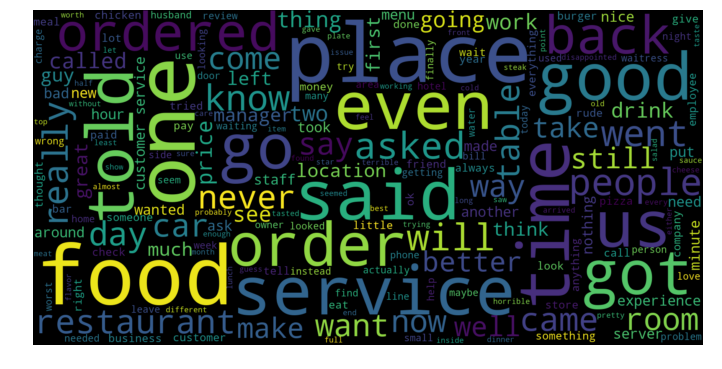

In [69]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()